# Imports etc.

In [1]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy
import statsmodels.formula.api as smf

from Functions import load_real_mouse_data, get_info_from_fullID, add_meta_column

In [2]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'

In [3]:
save_or_load_true_mouse_dat = 'save'  # 'save', 'load'
save_or_load_sim_mouse_dat = 'save'  # 'save', 'load'

# Function to format mouse data

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


,action,reward,correct,trial,block,fullID,agegroup,sex,age,animal,rew_1ago,rew_2ago,switch,block_length,block_trial,trials2switch,session,rew_12ago,meta
0,0.0,0.0,0,0,0.0,1404012,Juvenile,Male,40,14,NaN,NaN,NaN,12.0,NaN,NaN,0.0,nn,1-3
1,0.0,0.0,0,1,0.0,1404012,Juvenile,Male,40,14,0.0,NaN,0.0,12.0,NaN,NaN,0.0,0n,1-3
2,1.0,1.0,1,2,0.0,1404012,Juvenile,Male,40,14,0.0,0.0,1.0,12.0,NaN,NaN,0.0,00,1-3
3,1.0,1.0,1,3,0.0,1404012,Juvenile,Male,40,14,1.0,0.0,0.0,12.0,NaN,NaN,0.0,10,1-3
4,1.0,1.0,1,4,0.0,1404012,Juvenile,Male,40,14,1.0,1.0,0.0,12.0,NaN,NaN,0.0,11,1-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,1.0,0.0,0,410,15.0,1309021,Adult,Female,90,13,0.0,0.0,0.0,20.0,16.0,-4.0,18.0,00,nan
411,0.0,1.0,1,411,15.0,1309021,Adult,Female,90,13,0.0,0.0,1.0,20.0,17.0,-3.0,18.0,00,nan
412,0.0,1.0,1,412,15.0,1309021,Adult,Female,90,13,1.0,0.0,0.0,20.0,18.0,-2.0,18.0,10,nan
413,0.0,1.0,1,413,15.0,1309021,Adult,Female,90,13,1.0,1.0,0.0,20.0,19.0,-1.0,18.0,11,nan


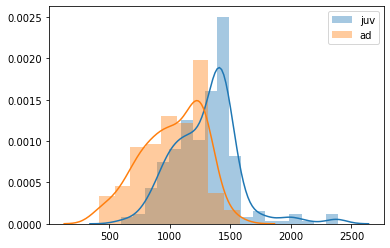

In [18]:
def format_mouse_data(raw_dat, save_as_csv=True, trials2switch_lower=3):
    
    true_dat = pd.DataFrame()
    for i, fullID in enumerate(raw_dat['fullIDs']):
        
        # Animal info
        subj_dat = {
            'action': raw_dat['actions'].loc[:, i],
            'reward': raw_dat['rewards'].loc[:, i],
            'correct': raw_dat['corrects'].loc[:, i],
            'trial': range(raw_dat['n_trials']),
            'block': np.append([0], np.cumsum(np.abs(np.diff(raw_dat['correct_actions'].loc[:, i])))),
            'fullID': [fullID] * raw_dat['n_trials'],
            }
        subj_dat = pd.DataFrame(subj_dat)
        for col in ['agegroup', 'sex', 'age', 'animal']:
            subj_dat[col] = get_info_from_fullID(fullID, col)

        # Session info (within animal)
        for age in np.unique(subj_dat.age):
            subj_dat.loc[subj_dat.age == age, 'rew_1ago'] = np.append(np.nan, subj_dat['reward'][:-1])
            subj_dat.loc[subj_dat.age == age, 'rew_2ago'] = np.append(np.nan, subj_dat['rew_1ago'][:-1])
            subj_dat.loc[subj_dat.age == age, 'switch'] = np.append(np.nan, np.abs(np.diff(subj_dat.action)))

            # Block info (within session, within animal)
            for block in np.unique(subj_dat.block):
                sub_idx = (subj_dat.block == block) * (subj_dat.age == age)
                block_length = sum(sub_idx)

                if block_length > trials2switch_lower + 2:
                    block_trial = range(block_length)
                    trials2switch = np.append(np.arange(block_length-trials2switch_lower),
                                              np.arange(-trials2switch_lower, 0))
                else:
                    block_trial = [np.nan] * block_length
                    trials2switch = [np.nan] * block_length

                subj_dat.loc[sub_idx, 'block_length'] = block_length
                subj_dat.loc[sub_idx, 'block_trial'] = block_trial
                subj_dat.loc[sub_idx, 'trials2switch'] = trials2switch

        true_dat = true_dat.append(subj_dat)

    # Session and gender
    for animal in np.unique(true_dat.animal):
        ani_age = true_dat.loc[true_dat.animal == animal, 'age']
        true_dat.loc[true_dat.animal == animal, 'session'] = ani_age - np.min(ani_age)
    true_dat['rew_12ago'] = [str(r1)[0] + str(r2)[0] for r1, r2 in zip(true_dat['rew_1ago'], true_dat['rew_2ago'])]
    true_dat['agegroup'] = pd.Categorical(true_dat.agegroup, categories=('Juvenile', 'Adult'), ordered=True)
    true_dat['meta'] = add_meta_column(true_dat)
    
    # Save as csv
    if save_as_csv:
        true_dat.to_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))
        
    return true_dat

# Example use
raw_dat = load_real_mouse_data()
true_dat = format_mouse_data(raw_dat, save_as_csv=True, trials2switch_lower=10)
true_dat

# Functions to load and format simulated data

In [ ]:
# Get remaining info for this simulation
def format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True):
    """
    Takes raw `sim_data` (e.g., read in from os.path.join(fitted_param_dir, 'simulations/simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents)))
    Adds all the columns necessary for behavioral analyses.
    """
    
    # Pull out behavior of one specific simulation into separate columns
    for col in ['actionall', 'rewardall', 'correctall']:
        sim_dat[col[:-3]] = sim_dat[col].apply(lambda x: x[1 + 2 * selected_mouse]).astype('int')
        
    # Add gender and session for each simulated animal
    for animal in np.unique(sim_dat.animal):
        print('animal {} / {}'.format(animal, len(np.unique(sim_dat.animal))))
        sub_idx_a = sim_dat.animal == animal
        sim_dat.loc[sub_idx_a, 'gender'] = get_info_from_fullID(sim_dat.loc[sub_idx_a, 'fullID'].reset_index(drop=True)[0], sum(sub_idx_a))['gender']
        sim_age = sim_dat.loc[sub_idx_a, 'age']
        sim_dat.loc[sub_idx_a, 'session'] = sim_age - min(sim_age)

        # Add rew_1ago, rew_2ago, switch for each session
        for age in np.unique(sim_dat.loc[sub_idx_a, 'age']):
            sub_idx_aa = (sim_dat.animal == animal) * (sim_dat.age == age)
            sim_dat.loc[sub_idx_aa, 'rew_1ago'] = np.append(np.nan, sim_dat.loc[sub_idx_aa, 'reward'][:-1])
            sim_dat.loc[sub_idx_aa, 'rew_2ago'] = np.append(np.nan, sim_dat.loc[sub_idx_aa, 'rew_1ago'][:-1])
            sim_dat.loc[sub_idx_aa, 'switch'] = np.append(np.nan, np.abs(np.diff(sim_dat.loc[sub_idx_aa, 'action'].astype('int'))))

            # Add block_length, block_trial, trials2swtich for each block
            for block in np.unique(sim_dat.loc[sub_idx_aa, 'block']):
                sub_idx_baa = (sim_dat.block == block) * (sim_dat.animal == animal) * (sim_dat.age == age)
                block_length = sum(sub_idx_baa)

                if block_length > 5:
                    block_trial = range(block_length)
                    trials2switch = np.append(np.arange(block_length-3), np.arange(-3, 0))
                else:
                    block_trial = [np.nan] * block_length
                    trials2switch = [np.nan] * block_length

                sim_dat.loc[sub_idx_baa, 'block_length'] = block_length
                sim_dat.loc[sub_idx_baa, 'block_trial'] = block_trial
                sim_dat.loc[sub_idx_baa, 'trials2switch'] = trials2switch

    # Format gender; add rew_12ago and agegroup
#     true_dat['gender'] = true_dat['gender'].replace({1: 'Male', 2: 'Female'})
    sim_dat['rew_12ago'] = [str(r1)[0] + str(r2)[0] for r1, r2 in zip(sim_dat['rew_1ago'], sim_dat['rew_2ago'])]
    sim_dat.loc[sim_dat.age > 65, 'agegroup'] = 'Adult'  # adults: 69-90
    sim_dat.loc[sim_dat.age < 65, 'agegroup'] = 'Juvenile'  # juveniles: 38-60

    # Save as csv
    if save_as_csv:
        sim_dat.to_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)), index=False)
        
    return sim_dat

# # Example use
# n_agents = 10
# modelnames = [f for f in os.listdir(fitted_param_dir) if ('.csv' in f) and ('params' in f) and ('B' not in f)]
# model_names = [modelname.split('_')[1] for modelname in modelnames]
# simulation_dir = os.path.join(fitted_param_dir, 'simulations/simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
# sim_dat = pd.read_csv(simulation_dir)
# format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)

# Functions to make plots

In [ ]:
def plot_session_n(data, suf):
    
    g = (gg.ggplot(data, gg.aes('session', fill='agegroup'))
         + gg.geom_bar(position=gg.position_dodge(width=0.9))
         + gg.facet_grid('~ gender')
         + gg.labs(y='n animals', color='')
        )
    
    g.draw()
    g.save(os.path.join(plot_dir, 'session_n{}.png'.format(suf)))

# Example use
plot_session_n(true_dat[true_dat.trial==0], 'mouse')

In [ ]:
def plot_meta_correct(data, suf):
    
    g = (gg.ggplot(data, gg.aes('meta', 'correct', color='agegroup', group='agegroup'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_grid('~ gender')
     + gg.labs(x='Sessions', color='')
    )
    
    g.draw()
    g.save(os.path.join(plot_dir, 'meta_correct_{}.png'.format(suf)))
    
# # Example use
# plot_meta_correct(true_dat, 'mouse')

In [ ]:
def make_12ago_plot(data, suf=''):
    
    sub_dat = data.loc[(data.rew_12ago != '0n') * (data.rew_12ago != '1n') * (data.rew_12ago != 'nn')]

    g = (gg.ggplot(sub_dat, gg.aes('rew_12ago', 'switch', fill='agegroup', group='agegroup'))
         + gg.stat_summary(geom='bar', position=gg.position_dodge(width=0.9))
         + gg.stat_summary(position=gg.position_dodge(width=0.9))
         + gg.facet_grid('meta ~ gender')
    )
    g.draw()
    g.save(os.path.join(plot_dir, 'rew12back_switch_{}.png'.format(suf)))
    
    g2 = g + gg.aes(y='correct')    
    g2.draw()
    g2.save(os.path.join(plot_dir, 'rew12back_correct_{}.png'.format(suf)))
    
    g3 = g + gg.aes(fill='meta', group='meta') + gg.facet_grid('agegroup ~ gender')
    g3.draw()
    g3.save(os.path.join(plot_dir, 'rew12back_meta_{}.png'.format(suf)))
    
# # Example use
# make_12ago_plot(true_dat, 'mouse')

In [ ]:
def make_blocktrial_correct_plot(data, suf):
    
    g = (gg.ggplot(data, gg.aes('block_trial', 'correct', color='agegroup'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.coord_cartesian(xlim=(0, 40))
     + gg.facet_grid('meta ~ gender')
    )
    g.draw()
    g.save(os.path.join(plot_dir, 'trial_correct_{}.png'.format(suf)))
    
    g2 = g + gg.aes(y='reward')    
    g2.draw()
    g2.save(os.path.join(plot_dir, 'trial_reward_{}.png'.format(suf)))
    
# # Example use
# make_blocktrial_correct_plot(true_dat, 'mouse')

In [ ]:
def make_trials2switch_plot(data, suf=''):
    
    g = (gg.ggplot(data, gg.aes('trials2switch', 'correct', color='agegroup', group='agegroup'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.coord_cartesian(xlim=(-3, 10))
     + gg.facet_grid('meta ~ gender')
    )
    g.draw()
    g.save(os.path.join(plot_dir, 'trials2switch_{}.png'.format(suf)))
    
    g2 = g + gg.aes(color='meta', group='meta') + gg.facet_grid('agegroup ~ gender')
    g2.draw()
    g2.save(os.path.join(plot_dir, 'trials2switch_meta_{}.png'.format(suf)))

# # Example use
# make_trials2switch_plot(true_dat, suf='mouse')

In [ ]:
def plot_asymptotic_correct(data, xlab, suf=''):
        
    g = (gg.ggplot(data, gg.aes(x=0, y='correct', color='agegroup'))
         + gg.stat_summary()
         + gg.stat_summary(geom='line')
#          + gg.coord_cartesian(ylim=(0.75, 1))
         + gg.theme(axis_text_x=gg.element_blank())
         + gg.labs(x=xlab, color='')
         + gg.facet_grid('meta ~ gender')
        )
    
    g.draw()
    g.save(os.path.join(plot_dir, 'asympt_{}.png'.format(suf)))
    
# # Example use
# sub_dat = true_dat[(true_dat.trials2switch <= -1)]
# plot_asymptotic_correct(sub_dat)

In [ ]:
def make_session_correct_plot(data, suf):

    g = (gg.ggplot(data, gg.aes('session', 'correct', color='agegroup'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_grid(' ~ gender')
    )
    g.draw()
    g.save(os.path.join(plot_dir, 'session_correct_{}.png'.format(suf)))
    
    g2 = g + gg.aes(y='reward')    
    g2.draw()
    g2.save(os.path.join(plot_dir, 'session_reward_{}.png'.format(suf)))
    
# # Example use
# make_session_correct_plot(true_dat, 'mouse')

In [ ]:
def make_age_reward_plot(data, suf):
    
    g = (gg.ggplot(data, gg.aes('age', 'correct', color='factor(meta)', group='factor(meta)'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_grid('agegroup ~ gender')
    )
    g.draw()
    g.save(os.path.join(plot_dir, 'age_correct_{}.png'.format(suf)))

    g2 = g + gg.aes(y='reward')    
    g2.draw()
    g2.save(os.path.join(plot_dir, 'age_reward_{}.png'.format(suf)))

    g3 = g + gg.aes(color='factor(session)', group='factor(session)')
    g3.draw()
    g3.save(os.path.join(plot_dir, 'age_correct_session_{}.png'.format(suf)))
    
# # Example use
# make_age_reward_plot(true_dat, 'mouse')

In [ ]:
def make_block_correct_plot(data, suf):
    
    g = (gg.ggplot(data, gg.aes('block', 'correct', color='agegroup', group='agegroup'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.coord_cartesian(xlim=(0, 20))
     + gg.facet_grid('meta ~ gender')
    )
    g.draw()
    g.save(os.path.join(plot_dir, 'block_correct_{}.png'.format(suf)))
    
    g2 = g + gg.aes(y='reward')    
    g2.draw()
    g2.save(os.path.join(plot_dir, 'block_reward_{}.png'.format(suf)))
    
    g3 = g + gg.aes(color='meta', group='meta') + gg.facet_grid('agegroup ~ gender')
    g3.draw()
    g3.save(os.path.join(plot_dir, 'block_correct_meta_{}.png'.format(suf)))
    
# # Example use
# make_block_correct_plot(true_dat, 'mouse')

# Putting it all together

## Number of trials per session (SLOW)

In [10]:
# Get ALL data (don't exclude any trials)
raw_dat = load_real_mouse_data(exclusion_percentile_ntrials=100)
true_dat = format_mouse_data(raw_dat, save_as_csv=True, trials2switch_lower=10)
true_dat

# Summarize over session to count number of trials
n_trial_dat = true_dat[['animal', 'session', 'action', 'sex', 'agegroup']
                      ].groupby(['animal', 'session', 'sex', 'agegroup']
                      ).agg(['count']).reset_index().rename(columns={'action': 'n_trials'})
n_trial_dat

,animal,session,sex,agegroup,n_trials
,,,,,count
0,1,0.0,Male,Adult,1252
1,1,1.0,Male,Adult,1198
2,1,2.0,Male,Adult,1490
3,1,3.0,Male,Adult,1181
4,1,4.0,Male,Adult,1213
...,...,...,...,...,...
436,37,9.0,Male,Juvenile,2016
437,37,11.0,Male,Juvenile,2008
438,37,13.0,Male,Juvenile,2349


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\0_sesssion_ntrials.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


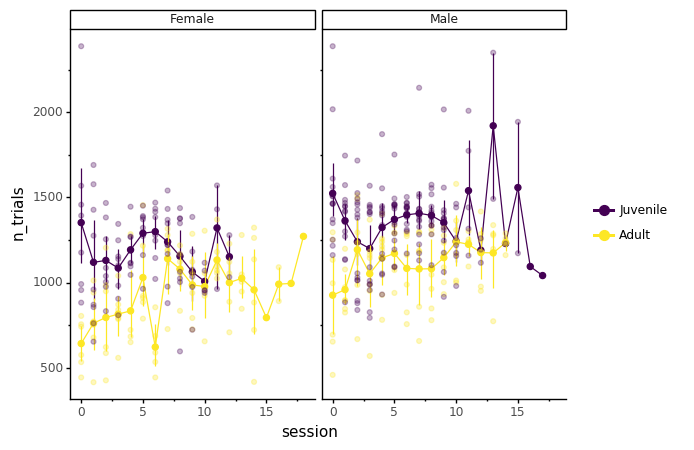

<ggplot: (191434685332)>

In [17]:
# Plot
g = (gg.ggplot(n_trial_dat, gg.aes('session', 'n_trials', color='agegroup'))
     + gg.stat_summary(geom='line')
     + gg.stat_summary()
     + gg.geom_point(alpha=0.3)
     + gg.facet_grid('~ sex')
     + gg.labs(color='')
    )
g.save(os.path.join(plot_dir, '0_sesssion_ntrials.png'))
g

## Analyze mouse data

In [ ]:
# Read in and format mouse data
print("Reading in mouse data...")
if save_or_load_true_mouse_dat == 'save':
    raw_dat = load_real_mouse_data()
    true_dat = format_mouse_data(raw_dat, save_as_csv=True)
else:
    true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'), index_col=0)
    
true_dat = add_meta_column(true_dat)
true_dat['agegroup'] = pd.Categorical(true_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))
true_dat

In [ ]:
# Plot mouse data
print("Plotting...")
sub_dat = true_dat[(true_dat.trials2switch <= -1)]
plot_asymptotic_correct(sub_dat, xlab='1-3 trials before switch', suf='bef_mouse')
sub_dat = true_dat[(true_dat.trials2switch >= 7) & (true_dat.trials2switch <= 12)]
plot_asymptotic_correct(sub_dat, xlab='7-12 trials after switch', suf='after_mouse')
plot_meta_correct(true_dat, suf='mouse')
make_trials2switch_plot(true_dat, suf='mouse')
make_12ago_plot(true_dat, 'mouse')
make_blocktrial_correct_plot(true_dat, 'mouse')
make_block_correct_plot(true_dat, 'mouse')
make_session_correct_plot(true_dat, 'mouse')
make_age_reward_plot(true_dat, 'mouse')

In [ ]:
sub_dat = true_dat.loc[(true_dat.trials2switch >= 1) & (true_dat.trials2switch <= 6)]
g = (gg.ggplot(sub_dat, gg.aes('trials2switch', 'correct', color='agegroup'))
 + gg.stat_summary()
 + gg.stat_summary(geom='line')
 + gg.facet_grid('meta ~ gender', scales='free')
)
g.draw()

g2 = g
g2.data = true_dat.loc[(true_dat.trials2switch >= 7) & (true_dat.trials2switch <= 12)]
g2.draw()

## Analyze simulated data

In [ ]:
# Define simulations to be analzed
n_agents = 100
modelnames = [f for f in os.listdir(fitted_param_dir) if ('.csv' in f) and ('params' in f)]
model_names = [modelname.split('_')[1] for modelname in modelnames]
print(model_names)
# model_names.reverse()
# model_names = [ 'Bbspr', 'Bbp', 'Bbpr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']

# Read in and format simulated data
for model_name in model_names:
    print("Model {}".format(model_name))
    simulation_dir = os.path.join(fitted_param_dir, 'simulations/simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
    if save_or_load_sim_mouse_dat == 'save':
        sim_dat = pd.read_csv(simulation_dir)
        sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
    else:
        sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
    sim_dat = add_meta_column(sim_dat)
    sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))
    
    # Plot simulated data
    print("Plotting...")
    make_trials2switch_plot(sim_dat, suf='sim' + model_name)
    make_12ago_plot(sim_dat, 'sim' + model_name)
    make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
    make_block_correct_plot(sim_dat, 'sim' + model_name)
    make_session_correct_plot(sim_dat, 'sim' + model_name)
    make_age_reward_plot(sim_dat, 'sim' + model_name)

# Run regression models

In [ ]:
# Summarize data for logistic regression
mean_dat = true_dat.groupby(['fullID', ]).mean().reset_index()
mean_dat['gender'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['gender'][0])
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['agegroup'][0])

mean_dat['meta'] = np.nan
mean_dat.loc[mean_dat.session <= 2, 'meta'] = '1-3'
mean_dat.loc[(mean_dat.session >= 3) * (mean_dat.session <= 7), 'meta'] = '4-8'
mean_dat.loc[(mean_dat.session >= 8) * (mean_dat.session <= 10), 'meta'] = '9-11'
mean_dat = mean_dat.dropna(subset=['meta'])
mean_dat['meta'] = pd.Categorical(mean_dat['meta'], ordered=True, categories=('1-3', '4-8', '9-11'))
# mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Agegroup differences in performace?
print(smf.ols(
    "correct ~ (session + gender + agegroup) * (session + gender + agegroup)",
    mean_dat,
).fit().summary())

# # from statsmodels.formula.api import logit
# smf.logit("affair ~ occupation + educ + occupation_husb"
#                    "+ rate_marriage + age + yrs_married + children"
#                    " + religious", dta).fit()

# Post-hoc t-tests
for meta in np.unique(mean_dat.meta):
    for gender in np.unique(mean_dat.gender):
        
        sub_dat = mean_dat[(mean_dat.meta == meta) * (mean_dat.gender == gender)]
        t, p = scipy.stats.ttest_ind(
            sub_dat.correct[sub_dat.agegroup == 'Juvenile'],
            sub_dat.correct[sub_dat.agegroup == 'Adult']
        )
        print("{}s, sessions {}: t={}, p={}".format(gender, meta, round(t, 1), round(p, 4)))

In [ ]:
# # Grand regression model
# print(smf.mixedlm(
#     "correct ~ (session + gender + agegroup) * (session + gender + agegroup)",
#     true_dat,
#     groups=true_dat["animal"]  # Default random effects structure: random intercept for each group
# ).fit().summary())

# # Post-hoc t-tests
# for meta in np.unique(true_dat.meta):
#     for gender in np.unique(true_dat.gender):
        
#         sub_dat = true_dat[(true_dat.meta == meta) * (true_dat.gender == gender)]
#         t, p = scipy.stats.ttest_ind(
#             sub_dat.correct[sub_dat.agegroup == 'Juvenile'],
#             sub_dat.correct[sub_dat.agegroup == 'Adult']
#         )
#         print("{}s, sessions {}: t={}, p={}".format(gender, meta, round(t, 1), round(p, 4)))

In [ ]:
true_dat['session2'] = 2 * np.round(true_dat.session / 2)
true_dat['session3'] = 3 * np.round(true_dat.session / 3)
sub = true_dat[(true_dat.agegroup == "Juvenile")]
g = (gg.ggplot(sub, gg.aes('age', 'correct', color='factor(session)', group='factor(session)'))
     + gg.stat_summary()
     + gg.stat_summary(geom="line")
     + gg.facet_grid('~ gender')
    )
g

In [ ]:
# Summarize data for regression
low, high = 1, 5
mean_dat = true_dat[
        (true_dat.trials2switch >= low) * (true_dat.trials2switch <= high) * (true_dat.meta == '1-3')
    ].groupby(['fullID']).mean().reset_index()
mean_dat['gender'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['gender'][0])
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['agegroup'][0])

mean_dat['meta'] = np.nan
mean_dat.loc[mean_dat.session <= 2, 'meta'] = '1-3'
mean_dat.loc[(mean_dat.session >= 3) * (mean_dat.session <= 7), 'meta'] = '4-8'
mean_dat.loc[(mean_dat.session >= 8) * (mean_dat.session <= 10), 'meta'] = '9-11'
mean_dat = mean_dat.dropna(subset=['meta'])
mean_dat['meta'] = pd.Categorical(mean_dat['meta'], ordered=True, categories=('1-3', '4-8', '9-11'))
# mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Agegroup differences in performace?
print(smf.ols(
    "correct ~ (trials2switch + session + gender + agegroup) * (trials2switch + session + gender + agegroup)",
    mean_dat,
).fit().summary())

In [ ]:
# Summarize data for regression
low, high = 1, 5
mean_dat = true_dat[
        (true_dat.trials2switch >= low) * (true_dat.trials2switch <= high)
    ].groupby(['fullID']).mean().reset_index()
mean_dat['gender'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['gender'][0])
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['agegroup'][0])

mean_dat['meta'] = np.nan
mean_dat.loc[mean_dat.session <= 2, 'meta'] = '1-3'
mean_dat.loc[(mean_dat.session >= 3) * (mean_dat.session <= 7), 'meta'] = '4-8'
mean_dat.loc[(mean_dat.session >= 8) * (mean_dat.session <= 10), 'meta'] = '9-11'
mean_dat = mean_dat.dropna(subset=['meta'])
mean_dat['meta'] = pd.Categorical(mean_dat['meta'], ordered=True, categories=('1-3', '4-8', '9-11'))
# mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Agegroup differences in performace?
print(smf.ols(
    "correct ~ (trials2switch + session + gender + agegroup) * (trials2switch + session + gender + agegroup)",
#     "correct ~ gender + trials2switch + session + agegroup + session:agegroup + trials2switch:session:agegroup + trials2switch:session",
    mean_dat,
).fit().summary())

In [ ]:
# Age group difference in early sessions?
low, hig = 1, 6
sub_dat_t = true_dat[(true_dat.meta == '0-2') * (true_dat.trials2switch >= low) * (true_dat.trials2switch < hig)]
print(smf.mixedlm(
    "correct ~ (trials2switch + gender + session + agegroup) * (trials2switch + gender + session + agegroup)",
    sub_dat_t,
    groups=sub_dat_t["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

# Do adults do more meta-learning than juveniles?
sub_dat_t = true_dat[(true_dat.trials2switch >= low) * (true_dat.trials2switch < hig)]
print(smf.mixedlm(
    "correct ~ (trials2switch + gender + session) * (trials2switch + gender + session) * agegroup",
    sub_dat_t,
    groups=sub_dat_t["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

In [ ]:
import numpy as np                                                                                         
import statsmodels.api as sm                                                                               
import pandas as pd                                                                                        
                                                                                                           
# create fake data                                                                                         
# y: binary response                                                                                       
# x: continuous predictor                                                                                  
# re: three class random intercepts                                                                        
fakedata = pd.DataFrame({'y' : np.random.sample(50).round(),                                               
                         'x' : np.random.sample(50),                                                       
                         're' : (np.random.sample(50)*2).round().astype(int).astype(str)})
                                                          
# this is implemented as I understand the doc:                                                             
binom_model = sm.BinomialBayesMixedGLM(                                                                    
                                       fakedata['y'], # endog                                              
                                       fakedata['x'][:, None], # exog                                      
                                       pd.get_dummies(fakedata['re']), # Array of covariates for the random
                                       np.r_[0, 0, 0]) # ident, columns of exog_vc                         
binom_result = binom_model.fit_vb()
print(binom_result.summary())

In [ ]:
fakedata

In [ ]:
import numpy as np                                                                                                              
import pandas as pd                                                                                                             
from statsmodels.genmod.bayes_mixed_glm import PoissonBayesMixedGLM, BinomialBayesMixedGLM                                      
                                                                                                                                
n = 1000                                                                                                                        
m = 50 # Number of groups                                                                                                       
grp = np.random.randint(0, m, n)                                                                                                
grp_efx = np.random.normal(size=m)                                                                                              
n_relapse_xmt = np.random.normal(size=n)                                                                                        
lpr = grp_efx[grp] + n_relapse_xmt                                                                                              
mn = np.exp(lpr)                                                                                                                
total_days_AU_MS = np.random.poisson(mn)                                                                                        
X = pd.DataFrame({"total_days_AU_MS": total_days_AU_MS,                                                                         
                  "f_id_site": grp,                                                                                             
                  "n_relapse_xmt": n_relapse_xmt})                                                                              
                                                                                                                                
formula = 'total_days_AU_MS ~ 1 + n_relapse_xmt'                                                                                
                                                                                                                                
glm_model = PoissonBayesMixedGLM.from_formula(formula=formula,                                                                  
                vc_formulas={'f_id_site': '0 + C(f_id_site)'}, data=X)                                                          
glm_results = glm_model.fit_map()                                                                                               
print(glm_results.summary())  

In [ ]:
print(smf.mixedlm(
    "correct ~ (agegroup + session + gender) * (agegroup + session + gender)",
    sub_dat,
    groups=sub_dat.animal
).fit().summary())

In [ ]:
# PC_sim_dir = "C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat"

In [ ]:
# # Define simulations to be analzed
# n_agents = 100
# PC_sim_name = [f for f in os.listdir(PC_sim_dir) if ('.csv' in f) and ('params' in f)]
# model_names = [modelname.split('_')[1] for modelname in modelnames]
# print(model_names)

In [ ]:

# simulation_dir = os.path.join(PC_sim_dir, 'PC_{}_*.csv'.format(model_name, n_agents))
# if save_or_load_sim_mouse_dat == 'save':
#     sim_dat = pd.read_csv(simulation_dir)
#     sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
# else:
#     sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
# sim_dat = add_meta_column(sim_dat)
# sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))

# # Plot simulated data
# print("Plotting...")
# make_trials2switch_plot(sim_dat, suf='sim' + model_name)
# make_12ago_plot(sim_dat, 'sim' + model_name)
# make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
# make_block_correct_plot(sim_dat, 'sim' + model_name)
# make_session_correct_plot(sim_dat, 'sim' + model_name)
# make_age_reward_plot(sim_dat, 'sim' + model_name)

In [ ]:

# # model_names = [ 'Bbspr', 'Bbp', 'Bbpr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']

# # Read in and format simulated data
# # for PC_sim_name in PC_sim_names:
#     print("Model {}".format(model_name))
#     simulation_dir = os.path.join(PC_sim_dir, 'simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
#     if save_or_load_sim_mouse_dat == 'save':
#         sim_dat = pd.read_csv(simulation_dir)
#         sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
#     else:
#         sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
#     sim_dat = add_meta_column(sim_dat)
#     sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))
    
#     # Plot simulated data
#     print("Plotting...")
#     make_trials2switch_plot(sim_dat, suf='sim' + model_name)
#     make_12ago_plot(sim_dat, 'sim' + model_name)
#     make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
#     make_block_correct_plot(sim_dat, 'sim' + model_name)
#     make_session_correct_plot(sim_dat, 'sim' + model_name)
#     make_age_reward_plot(sim_dat, 'sim' + model_name)